---
title: "Unsupervised Learning"
format:
    html: 
        code-fold: false
---

<!-- After digesting the instructions, you can delete this cell, these are assignment instructions and do not need to be included in your final submission.  -->

{{< include instructions.qmd >}} 

# Code 

Provide the source code used for this section of the project here.

If you're using a package for code organization, you can import it at this point. However, make sure that the **actual workflow steps**—including data processing, analysis, and other key tasks—are conducted and clearly demonstrated on this page. The goal is to show the technical flow of your project, highlighting how the code is executed to achieve your results.

If relevant, link to additional documentation or external references that explain any complex components. This section should give readers a clear view of how the project is implemented from a technical perspective.

Remember, this page is a technical narrative, NOT just a notebook with a collection of code cells, include in-line Prose, to describe what is going on.

In [234]:
# import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, set_link_color_palette




In [235]:
import warnings
warnings.filterwarnings("ignore")

In [236]:
# load the data
df = pd.read_csv("../../data/processed-data/race_track_features.csv")
df.head()

,Year,Grand Prix,Track Length (m),Max Speed (km/h),Full Throttle (%),Number of Corners,Number of Straights,Unnamed: 7
0,2020,Pre-Season Test 1,-1.000607,-0.115670,1.059667,-0.789651,-0.938394,NaN
1,2020,Pre-Season Test 2,-1.000607,-0.115670,1.059667,-0.789651,-0.938394,NaN
2,2020,Austrian Grand Prix,-1.000607,-0.115670,1.059667,-0.789651,-0.938394,NaN
3,2020,Styrian Grand Prix,-1.024865,-1.840980,-1.757479,-0.275003,-0.037811,NaN
4,2020,Hungarian Grand Prix,-0.957039,-0.490737,-0.407433,-1.304300,-0.037811,NaN


In [237]:
# clustering with K-Means

In [238]:
# hyperparameter tuning
req_cols = ["Track Length (m)", "Max Speed (km/h)", "Full Throttle (%)", "Number of Corners", "Number of Straights"]

# Initialize lists to store evaluation metrics
em = []  # For inertia (WCSS)
ss = []  # For silhouette scores
for i in range(2,10):
    kmeans = KMeans(n_clusters = i).fit(df[req_cols])
    
    # intertia = within cluster sum of sqaures (WCSS)
    em.append(kmeans.inertia_)
    # silhouette scores
    score = silhouette_score(df[req_cols], kmeans.labels_)
    ss.append(score)

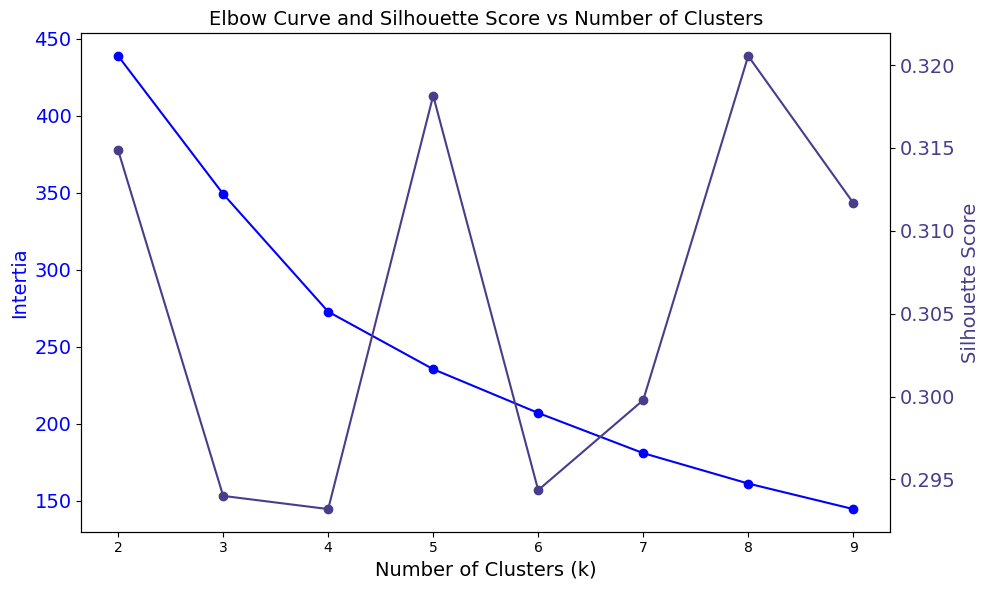

In [239]:
k_values = range(2, 10)

fig, ax1 = plt.subplots(figsize=(10, 6))

# First y-axis for Intertia 
ax1.plot(k_values, em, 'blue', marker='o', label='Inertia Score') 
ax1.set_xlabel("Number of Clusters (k)", fontsize=14)
ax1.set_ylabel("Intertia", color ='blue', fontsize=14)
ax1.tick_params(axis='y', labelcolor ='blue', labelsize=14)

# Second y-axis for silhouette scores
ax2 = ax1.twinx()
ax2.plot(k_values, ss, 'darkslateblue',marker='o', label='Silhouette Score') 
ax2.set_ylabel("Silhouette Score", color = 'darkslateblue', fontsize=14)
ax2.tick_params(axis='y', labelcolor ='darkslateblue', labelsize=14)

# Title
plt.title("Elbow Curve and Silhouette Score vs Number of Clusters", fontsize=14)
fig.tight_layout()
plt.show()

In [240]:
# Initializing and fitting the KMeans model with the optimal number of clusters
clusters = 5
kmeans = KMeans(n_clusters=clusters, random_state=123, n_init='auto')
kmeans.fit(df[req_cols])

# Predicting cluster labels
df['cluster-kmeans'] = kmeans.labels_
df.head()

,Year,Grand Prix,Track Length (m),Max Speed (km/h),Full Throttle (%),Number of Corners,Number of Straights,Unnamed: 7,cluster-kmeans
0,2020,Pre-Season Test 1,-1.000607,-0.115670,1.059667,-0.789651,-0.938394,NaN,1
1,2020,Pre-Season Test 2,-1.000607,-0.115670,1.059667,-0.789651,-0.938394,NaN,1
2,2020,Austrian Grand Prix,-1.000607,-0.115670,1.059667,-0.789651,-0.938394,NaN,1
3,2020,Styrian Grand Prix,-1.024865,-1.840980,-1.757479,-0.275003,-0.037811,NaN,2
4,2020,Hungarian Grand Prix,-0.957039,-0.490737,-0.407433,-1.304300,-0.037811,NaN,1


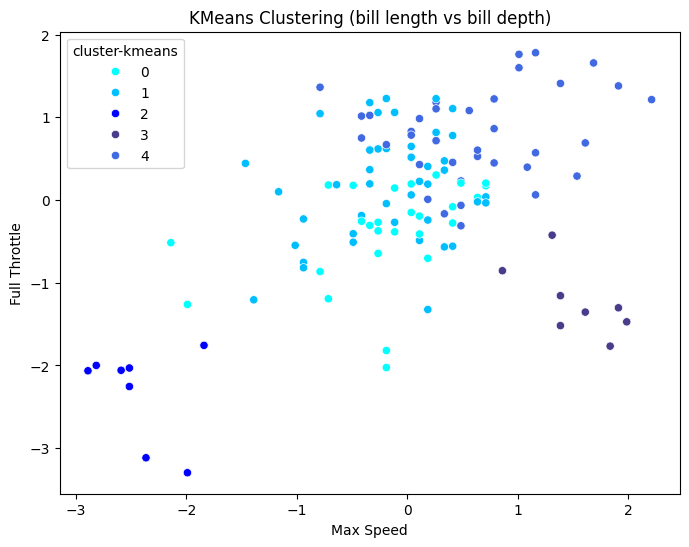

In [241]:
custom_colors = ["cyan", "deepskyblue", "blue", "darkslateblue", "royalblue"]

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Max Speed (km/h)'], y=df['Full Throttle (%)'], hue=df['cluster-kmeans'], palette=custom_colors)
plt.title('KMeans Clustering (bill length vs bill depth)')

plt.xlabel('Max Speed')
plt.ylabel('Full Throttle')
plt.show()

In [244]:
# DBSCAN

In [245]:
df = pd.read_csv("../../data/processed-data/race_track_features.csv")
features = df[["Track Length (m)", "Max Speed (km/h)", "Full Throttle (%)", "Number of Corners", "Number of Straights"]]

In [246]:
eps_range = np.arange(0.1, 2.0, 0.1)
# Range for min_samples to test
min_samples_range = range(1, 20)

# Variables to store the best results
best_score = -1
opt_eps = None
best_min_samples = None
best_cluster_count = None

# Loop through each combination of eps and min_samples
for eps in eps_range:
    for min_samples in min_samples_range:
        # Initialize DBSCAN with the current parameters
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        # Predict cluster labels
        labels = dbscan.fit_predict(features)
        
        # Ignore configurations that result in a single cluster or all points being noise
        if len(set(labels)) > 1:
            # Calculate silhouette score for the current parameters
            score = silhouette_score(features, labels)
            
            # Update best parameters if the current score is the highest
            if score > best_score:
                best_score = score
                opt_eps = eps
                best_min_samples = min_samples
                # Count clusters excluding noise
                best_cluster_count = len(set(labels)) - (1 if -1 in labels else 0)

# Print the optimal parameters and corresponding silhouette score
print("Best Silhouette Score:", best_score)
print("Optimal eps:", opt_eps)
print("Optimal min_samples:", best_min_samples)
print("Optimal number of clusters:", best_cluster_count)

Best Silhouette Score: 0.4901591287514251
Optimal eps: 0.4
Optimal min_samples: 5
Optimal number of clusters: 1


In [247]:
best_min_samples = best_min_samples
optimal_eps = opt_eps

# Initializing and fitting the DBSCAN model with the optimal parameters
dbscan = DBSCAN(eps = opt_eps, min_samples = best_min_samples)
labels_final = dbscan.fit_predict(features)

In [256]:
df['clusters-dbscan'] = labels_final


In [242]:
# Hierarchical Clustering

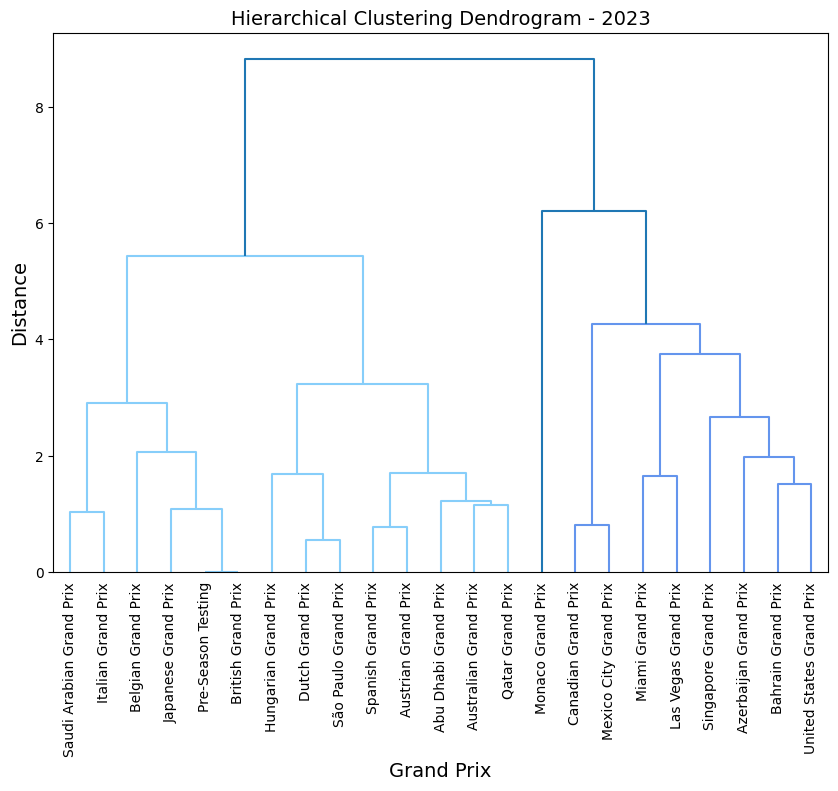

In [243]:
set_link_color_palette(["lightskyblue", "cornflowerblue", "blue", "steelblue"])

df = pd.read_csv("../../data/processed-data/race_track_features.csv")
df = df[df["Year"] == 2023]

features = ["Track Length (m)", "Max Speed (km/h)", "Full Throttle (%)", "Number of Corners", "Number of Straights"]
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

linkage_matrix = linkage(X_scaled, method='ward')  

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=df["Grand Prix"].values, leaf_rotation=90, leaf_font_size=10,color_threshold=6)
plt.title("Hierarchical Clustering Dendrogram - 2023", fontsize = 14)

plt.xlabel("Grand Prix", fontsize = 14)
plt.ylabel("Distance", fontsize = 14)
plt.show()

max_distance = 6
clusters = fcluster(linkage_matrix, max_distance, criterion='distance')

